In [1]:
import pickle
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import scipy.fftpack
import glob,os
import gwPaPa_func as gwpapa

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from skimage.util.shape import view_as_windows

import tensorflow as tf
from tensorflow import keras

import pickle
from pycbc import frame,types
import timeit

PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1


In [2]:
###timer
start = timeit.default_timer()

In [3]:
BNS_test_path='data_BNS'
BNS_check_path='data_BNS_check'
BBH_test_path='data_BBH'
BBH_check_path='data_BBH_check'

### Unpack Data

In [4]:
injections_BNS = pickle.load(open(BNS_test_path+'/injections-BNS.p', "rb"))
injections_BBH = pickle.load(open(BBH_test_path+'/injections-BBH.p', "rb"))
injections_BNS_check = pickle.load(open(BNS_check_path+'/injections-BNS.p', "rb"))
injections_BBH_check = pickle.load(open(BBH_check_path+'/injections-BBH.p', "rb"))

In [5]:
injections_BBH[2]

[{'sim-id': 'BBH-3',
  'mass_1': 14.860339404093695,
  'mass_2': 10.124717405353438,
  'S1x': 0.0,
  'S1y': 0.0,
  'S1z': 0.0,
  'S2x': 0.0,
  'S2y': 0.0,
  'S2z': 0.0,
  'distance': 1000.0,
  'inclination': 0.0,
  'right_ascension': 0.3,
  'declination': -0.4,
  'psi': 0.0,
  'phiRef': 0.0,
  'lambda1': 0.0,
  'lambda2': 0.0,
  'f_min': 20.0,
  'f_ref': 20.0,
  'deltaT': 0.000244140625,
  'start_time': 987,
  'duration': 17},

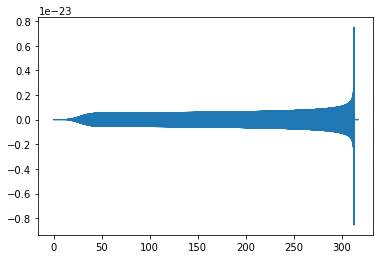

In [343]:
sample_rate=4096
t=np.arange(0,400,1/sample_rate)

try:
    d0 =injections_BNS_check[2][1]
    t0 = np.arange(0,len(d0)/sample_rate,1/sample_rate)
    plt.plot(t0,d0)
    plt.show()
except:
    pass

In [7]:
num_BNS_injections=len(injections_BNS)
num_BBH_injections=len(injections_BBH)
num_BNS_injections_check=len(injections_BNS_check)
num_BBH_injections_check=len(injections_BBH_check)

print(num_BNS_injections)
print(num_BBH_injections)
print(len(injections_BNS_check))
print(len(injections_BBH_check))


BNS_data=[]
BBH_data=[]
BNS_check_data=[]
BBH_check_data=[]
train_labels=[]
check_labels=[]
t0=50
tl=1

for i in range(len(injections_BNS)):
    d = np.array(injections_BNS[i][1])
    t = np.arange(0,len(d)/sample_rate,1/sample_rate)
    BNS_data.append(gwpapa.twindow(t,d,t0,tl))
    train_labels.append(1)
    
for i in range(len(injections_BNS_check)):
    d = np.array(injections_BNS_check[i][1])
    t = np.arange(0,len(d)/sample_rate,1/sample_rate)
    BNS_check_data.append(gwpapa.twindow(t,d,t0,tl))
    check_labels.append(1)
 
t0=7
tl=1

for i in range(len(injections_BBH)):
    d = np.array(injections_BBH[i][1])
    t = np.arange(0,len(d)/sample_rate,1/sample_rate)
    BBH_data.append(gwpapa.twindow(t,d,t0,tl))
    train_labels.append(0)
    
for i in range(len(injections_BBH_check)):
    d = np.array(injections_BBH_check[i][1])
    t = np.arange(0,len(d)/sample_rate,1/sample_rate)
    BBH_check_data.append(gwpapa.twindow(t,d,t0,tl))
    check_labels.append(0)

print('done')

180
180
20
20
done


0.0 0.99951171875


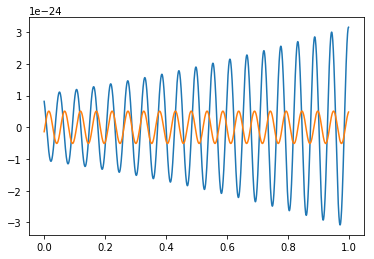

[8.17946428e-25 8.00289893e-25 7.81999660e-25 ... 3.15115465e-24
 3.15484124e-24 3.15613873e-24]


In [344]:
t=np.arange(0,len(BNS_data[0])/sample_rate,1/sample_rate)
t2=np.arange(0,len(BBH_data[0])/sample_rate,1/sample_rate)
print(0.0,max(t))
plt.plot(t,BBH_data[0])
plt.plot(t2,BNS_check_data[2])
plt.show()

print(BBH_data[0])

### Process Data

In [70]:
class_names=["BNS","BBH"]
added_noise=False

BNS_data=np.array(BNS_data)
BBH_data=np.array(BBH_data)
BNS_check_data=np.array(BNS_check_data)
BBH_check_data=np.array(BBH_check_data)
train_labels=np.array(train_labels)
check_labels=np.array(check_labels)
BNS_data.shape
BBH_data.shape
train_labels=np.array(train_labels)
BNS_check_data.shape
BBH_check_data.shape


BNS_data[int(num_BNS_injections/2):int(num_BNS_injections)].shape

(90, 4095)

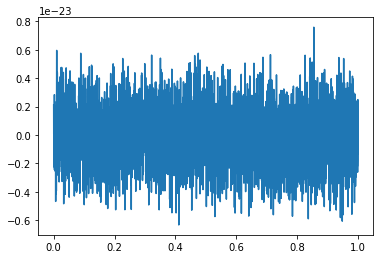

In [538]:
#if added_noise==False:
    
train_data=np.concatenate((BNS_data,BBH_data*0),axis=0)
check_data=np.concatenate((BNS_check_data,BBH_check_data*0),axis=0)
noise_amplitude=2*10**(-24)
    
noise_BNS = noise_amplitude*np.random.normal(size=BNS_data[int(num_BNS_injections/2):int(num_BNS_injections)].shape)
noise_BBH = noise_amplitude*np.random.normal(size=BBH_data[int(num_BBH_injections/2000):int(num_BBH_injections)].shape)
noise_BNS_check = noise_amplitude*np.random.normal(size=BNS_data[int(num_BNS_injections_check/200):int(num_BNS_injections_check)].shape)
noise_BBH_check = noise_amplitude*np.random.normal(size=BBH_data[int(num_BBH_injections_check/200):int(num_BBH_injections_check)].shape)

plt.plot(t,noise_BNS[0])
plt.show()

train_data[int(num_BNS_injections/2):int(num_BNS_injections)] += noise_BNS
train_data[int(num_BBH_injections/2000+num_BNS_injections):int(num_BBH_injections+num_BNS_injections)] += noise_BBH
check_data[int(num_BNS_injections_check/200):int(num_BNS_injections_check)] += noise_BNS_check
check_data[int(num_BBH_injections_check/200+num_BNS_injections_check):int(num_BBH_injections_check+num_BNS_injections_check)] += noise_BBH_check
    
    
    
train_data = train_data / np.linalg.norm(train_data)
check_data = check_data / np.linalg.norm(check_data)

    
#added_noise=True

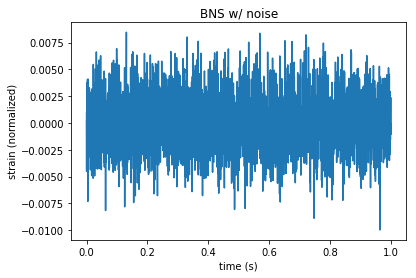

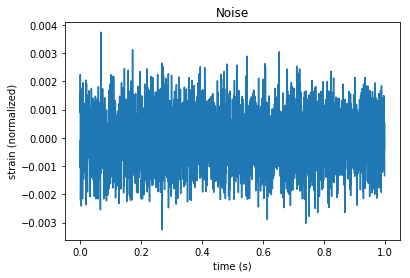

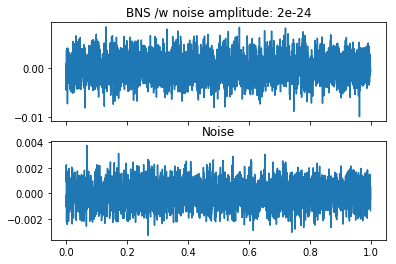

In [539]:
t=np.arange(0,len(BNS_data[100])/sample_rate,1/sample_rate)
t2=np.arange(0,len(BBH_data[100])/sample_rate,1/sample_rate)
#print(0.0,max(t))
plt.plot(t,check_data[10])
plt.title('BNS w/ noise')
plt.xlabel('time (s)')
plt.ylabel('strain (normalized)')
plt.show()
plt.plot(t,train_data[180])
plt.title('Noise')
plt.xlabel('time (s)')
plt.ylabel('strain (normalized)')
plt.show()


f, axarr = plt.subplots(2, sharex=True)
#f.suptitle('Sharing X axis')
axarr[0].plot(t, check_data[10])
axarr[0].set_title('BNS /w noise amplitude: '+str(noise_amplitude))
axarr[1].plot(t, train_data[180])
axarr[1].set_title('Noise')
#f.savefig('pics/timeseries'+str(noise_amplitude)+'.png',dpi=200)
f.show()

#plt.plot(t,BNS_data[120])
#plt.plot(t2,BBH_data[140])

### Make Machine Learning Model

In [622]:
model = keras.Sequential([
    keras.layers.Conv1D(64,1000, activation=tf.nn.relu,input_shape=(4095,1)),#512,2),
    keras.layers.Dense(256, activation=tf.nn.relu),
    #keras.layers.Dense(128, activation=tf.nn.relu),
    keras.layers.Dense(32, activation=tf.nn.relu),
    keras.layers.Dense(2, activation=tf.nn.softmax)
])


In [623]:
model.compile(optimizer=tf.train.AdamOptimizer(), 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

#print(model)
print(train_labels)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [624]:
model.fit(train_data, train_labels, epochs=20)

ValueError: Error when checking input: expected conv1d_20_input to have 3 dimensions, but got array with shape (360, 4095)

### Test Model

In [594]:
test_loss, test_acc = model.evaluate(check_data,check_labels)

print('Test accuracy:', test_acc)
print('Test Loss:', test_loss)

40/40 [==============================] - 1s 25ms/step
Test accuracy: 0.6
Test Loss: 1.4094722270965576


In [595]:
predictions = model.predict(check_data)

In [596]:
print(predictions[0],predictions[-1])
print(check_labels[0],check_labels[-1])
#print(t)

[6.9602061e-04 9.9930394e-01] [0.08192085 0.9180791 ]
1 0


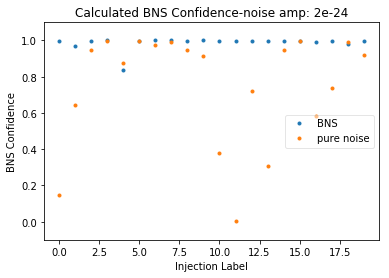

In [597]:
plt.plot(predictions[:num_BNS_injections_check,1],'.',label='BNS')
plt.plot(predictions[num_BNS_injections_check:num_BNS_injections_check+num_BBH_injections_check,1],'.',label='pure noise')
#plt.plot(predictions[:,1])
plt.ylabel('BNS Confidence')
plt.xlabel('Injection Label')
plt.title('Calculated BNS Confidence-noise amp: '+str(noise_amplitude))
plt.legend(loc='right',framealpha=.5)
plt.ylim(-.1,1.1)
#plt.savefig('pics/'+str(noise_amplitude)+'.png',dpi=200)
plt.show()


#plt.plot(predictions[:,1])
#plt.ylabel('BBH Confidence')
#plt.xlabel('Injection Number')
#plt.title('Calculated BBH Confidence for test BBH injections')
#plt.show()

In [598]:
stop = timeit.default_timer()

In [599]:
acttime=stop - start

print(str(acttime)+' seconds')
print(0.0,str((acttime)/60)+' minutes')
print(str((acttime)/3600)+' hours')

21287.927752235002 seconds
0.0 354.7987958705834 minutes
5.913313264509723 hours
